In [13]:
import os

import numpy as np

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
DATAFRAMES = os.path.join("..", "..", "..", "results", "dataframes", "")
FIGURES = os.path.join("..", "..", "..", "results", "figures", "")

# Data preprocessing

In [15]:
df_DC = pd.read_csv(os.path.join(DATAFRAMES, "dataframe_DC-real.csv"))
df_DC["embedding"] = ["DC"]*len(df_DC)
df_DC = df_DC.rename(columns={"pfi": "theta"})
df_DC = df_DC.query("theta > 0")
df_DC.head()

,system,layers,theta,auroc,embedding
1,arxiv,2-6,0.05,0.57,DC
2,arxiv,2-6,0.10,0.64,DC
3,arxiv,2-6,0.15,0.63,DC
4,arxiv,2-6,0.20,0.68,DC
5,arxiv,2-6,0.25,0.69,DC


In [16]:
# Load data
df = pd.read_csv(os.path.join(DATAFRAMES, f"dataframe_reals.csv"))
df = pd.concat([df_DC, df])

print(df.columns)

Index(['system', 'layers', 'theta', 'auroc', 'embedding', 'accuracy', 'pr',
       'intercept', 'coef_distances', 'coef_degrees'],
      dtype='object')


In [17]:
# Global transformations
df["relative_impact"] = np.abs(df["coef_distances"]) / (np.abs(df["coef_degrees"]) + np.abs(df["coef_distances"]))

In [18]:
# Global melts for easier declarative plotting
df = df.melt(
    id_vars=["system", "embedding", "layers", "theta", "intercept", "coef_distances", "coef_degrees", "relative_impact"],
    value_vars=["accuracy", "auroc", "pr"],
    var_name="perftype", value_name="perfval"
).melt(
    id_vars=["system", "embedding", "layers", "theta", "perftype", "perfval"],
    value_vars=["intercept", "coef_distances", "coef_degrees", "relative_impact"],
    var_name="featuretype",
    value_name="featureval"
)

# Figures

## Performance

In [19]:
df_ = df.query("perftype == 'auroc'")
THETAS = sorted(df_.query("embedding != 'DC'")["theta"].unique())

<Figure size 640x480 with 0 Axes>

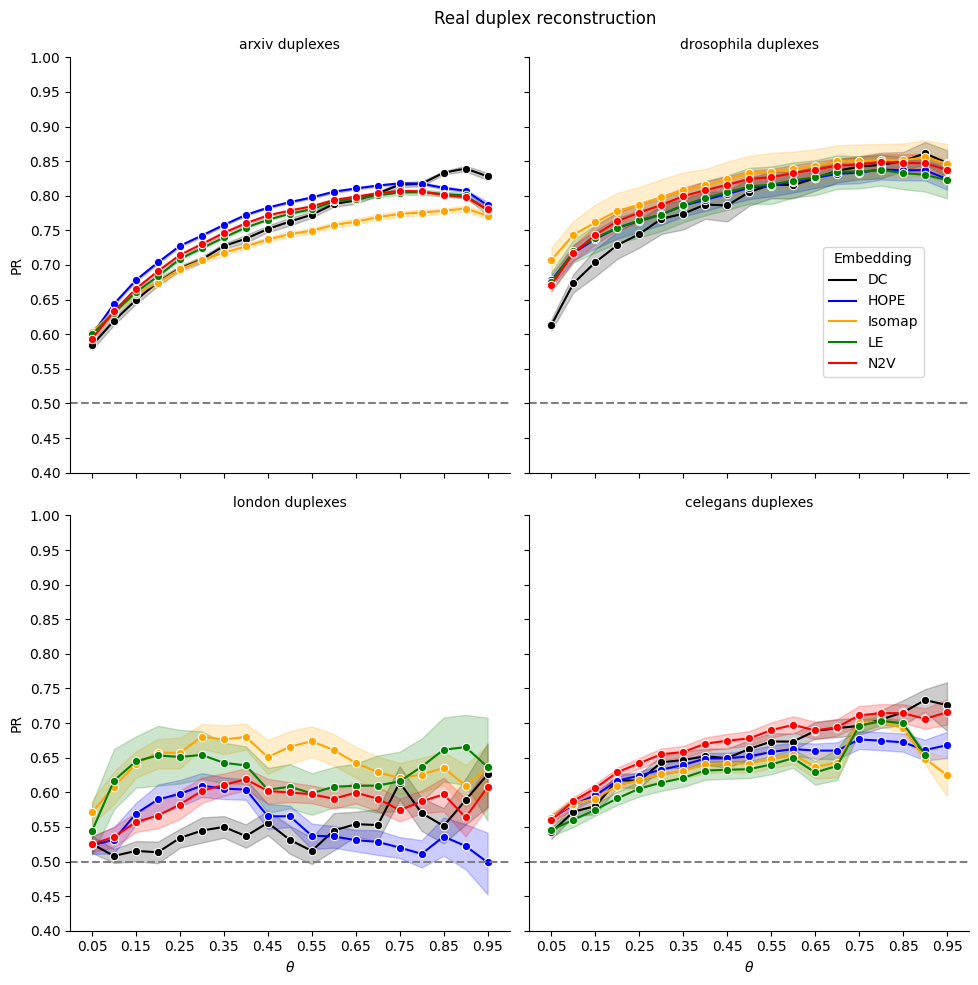

In [23]:
# Instantiate figure
plt.figure()

# Plot data
g = sns.relplot(
    data=df_, kind="line",
    x="theta", y="perfval",
    hue="embedding", palette=["black", "blue", "orange", "green", "red"],
    col="system", col_wrap=2,
    marker="o",
)

# Adjust axes
g.set_axis_labels(r'$\theta$', 'PR')
g.set(
    xlim=(0,1), xticks=THETAS[::2],
    ylim=(0.4, 1), yticks=np.linspace(0.4, 1.0, 13)
)
g.tick_params(axis="x", labelrotation=00)
g.tick_params(axis="y", which="minor")

# Adjust subplots
g.set_titles(col_template="{col_name} duplexes")
g.fig.subplots_adjust(top=0.9)
g.refline(y=0.5)

# Adjust figure
g.fig.suptitle("Real duplex reconstruction")
sns.move_legend(g,
    loc="upper right", bbox_to_anchor=(0.85, 0.75),
    title="Embedding",
    frameon=True)

# Save to disk
g.tight_layout()
# g.savefig(
#     os.path.join(FIGURES, "figure_auroc-pfi_hue-embedding_col-ex_data-ex01-thru-ex05.png"),
#     transparent=False,
#     facecolor="white",
#     dpi=600)

## Coefficients

In [24]:
df_ = df_.query("featuretype == 'relative_impact'")
df_["featureval"] = df_["featureval"].apply(lambda x: np.abs(x))

<Figure size 640x480 with 0 Axes>

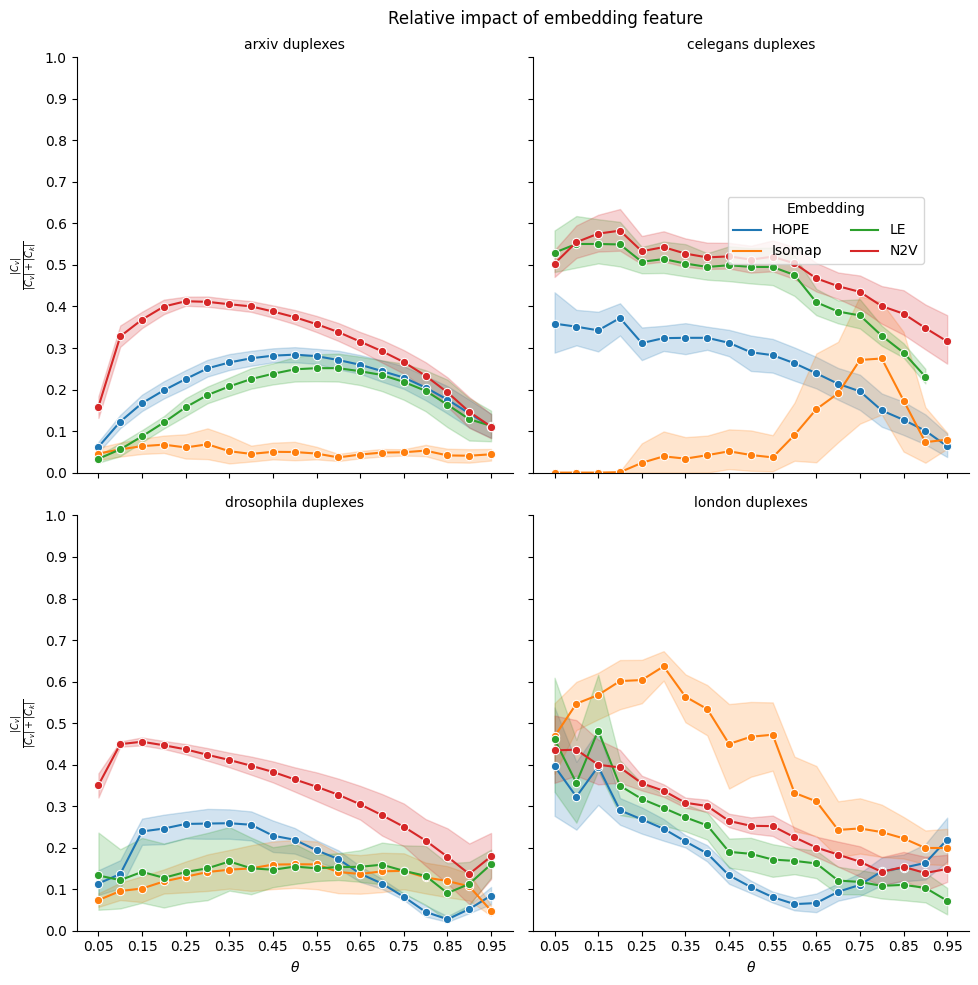

In [25]:
# Instantiate figure
plt.figure()

# Plot data
g = sns.relplot(
    data=df_, kind="line",
    x="theta", y="featureval",
    hue="embedding",
    col="system", col_wrap=2,
    marker="o",
)

# Adjust axes
g.set_axis_labels(r'$\theta$', r'$\frac{|C_v|}{|C_v| + |C_k|}$')
g.set(
    xlim=(0,1), xticks=THETAS[::2],
    ylim=(0.0, 1), yticks=np.linspace(0.0, 1.0, 11)
)
g.tick_params(axis="x", labelrotation=00)
g.tick_params(axis="y", which="minor")

# Adjust subplots
g.set_titles(col_template="{col_name} duplexes")
g.fig.subplots_adjust(top=0.9)

# Adjust figure
g.fig.suptitle("Relative impact of embedding feature")
sns.move_legend(g,
    loc="upper right", bbox_to_anchor=(0.85, 0.8),
    title="Embedding",
    ncol=2,
    frameon=True)

# Save to disk
g.tight_layout()
# g.savefig(
#     os.path.join(FIGURES, "figure_coef-pfi_hue-embedding_col-ex_data-ex01-thru-ex05.png"),
#     transparent=False,
#     facecolor="white",
#     dpi=600)